In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# Load data
import pandas as pd

data = pd.read_csv("../data/ADS_baselineDataset.csv", index_col=0)

In [2]:
# Split data
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Clustering

We still prerpocess the data, as clustering is heavily affected by outliers and Near-Zero variance features.

In [3]:
import sys

sys.path.append("..")
from src.pipeline import PreprocessingPipeline

preprocessing_pipeline = PreprocessingPipeline(
    frequency_threshold=0.9, outlier_threshold=1.25
)
X, y = preprocessing_pipeline.fit_transform(X, y)

Found 580 columns with Near-Zero Variance


In [4]:
sys.path.append("..")
from src.clustering import compare_clusters
from sklearn.cluster import KMeans, AgglomerativeClustering

n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
compare_clusters(X, kmeans, hierarchical)

,CLUSTER 1 (PARTITION 2),CLUSTER 2 (PARTITION 2)
CLUSTER 1 (PARTITION 1),15,160
CLUSTER 2 (PARTITION 1),222,80


In [5]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
compare_clusters(X, kmeans, hierarchical)

,CLUSTER 1 (PARTITION 2),CLUSTER 2 (PARTITION 2),CLUSTER 3 (PARTITION 2)
CLUSTER 1 (PARTITION 1),67,112,10
CLUSTER 2 (PARTITION 1),53,19,90
CLUSTER 3 (PARTITION 1),120,3,3


In [6]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
compare_clusters(X, kmeans, hierarchical)

,CLUSTER 1 (PARTITION 2),CLUSTER 2 (PARTITION 2),CLUSTER 3 (PARTITION 2),CLUSTER 4 (PARTITION 2)
CLUSTER 1 (PARTITION 1),35,4,1,2
CLUSTER 2 (PARTITION 1),8,38,98,68
CLUSTER 3 (PARTITION 1),45,15,0,61
CLUSTER 4 (PARTITION 1),38,57,4,3


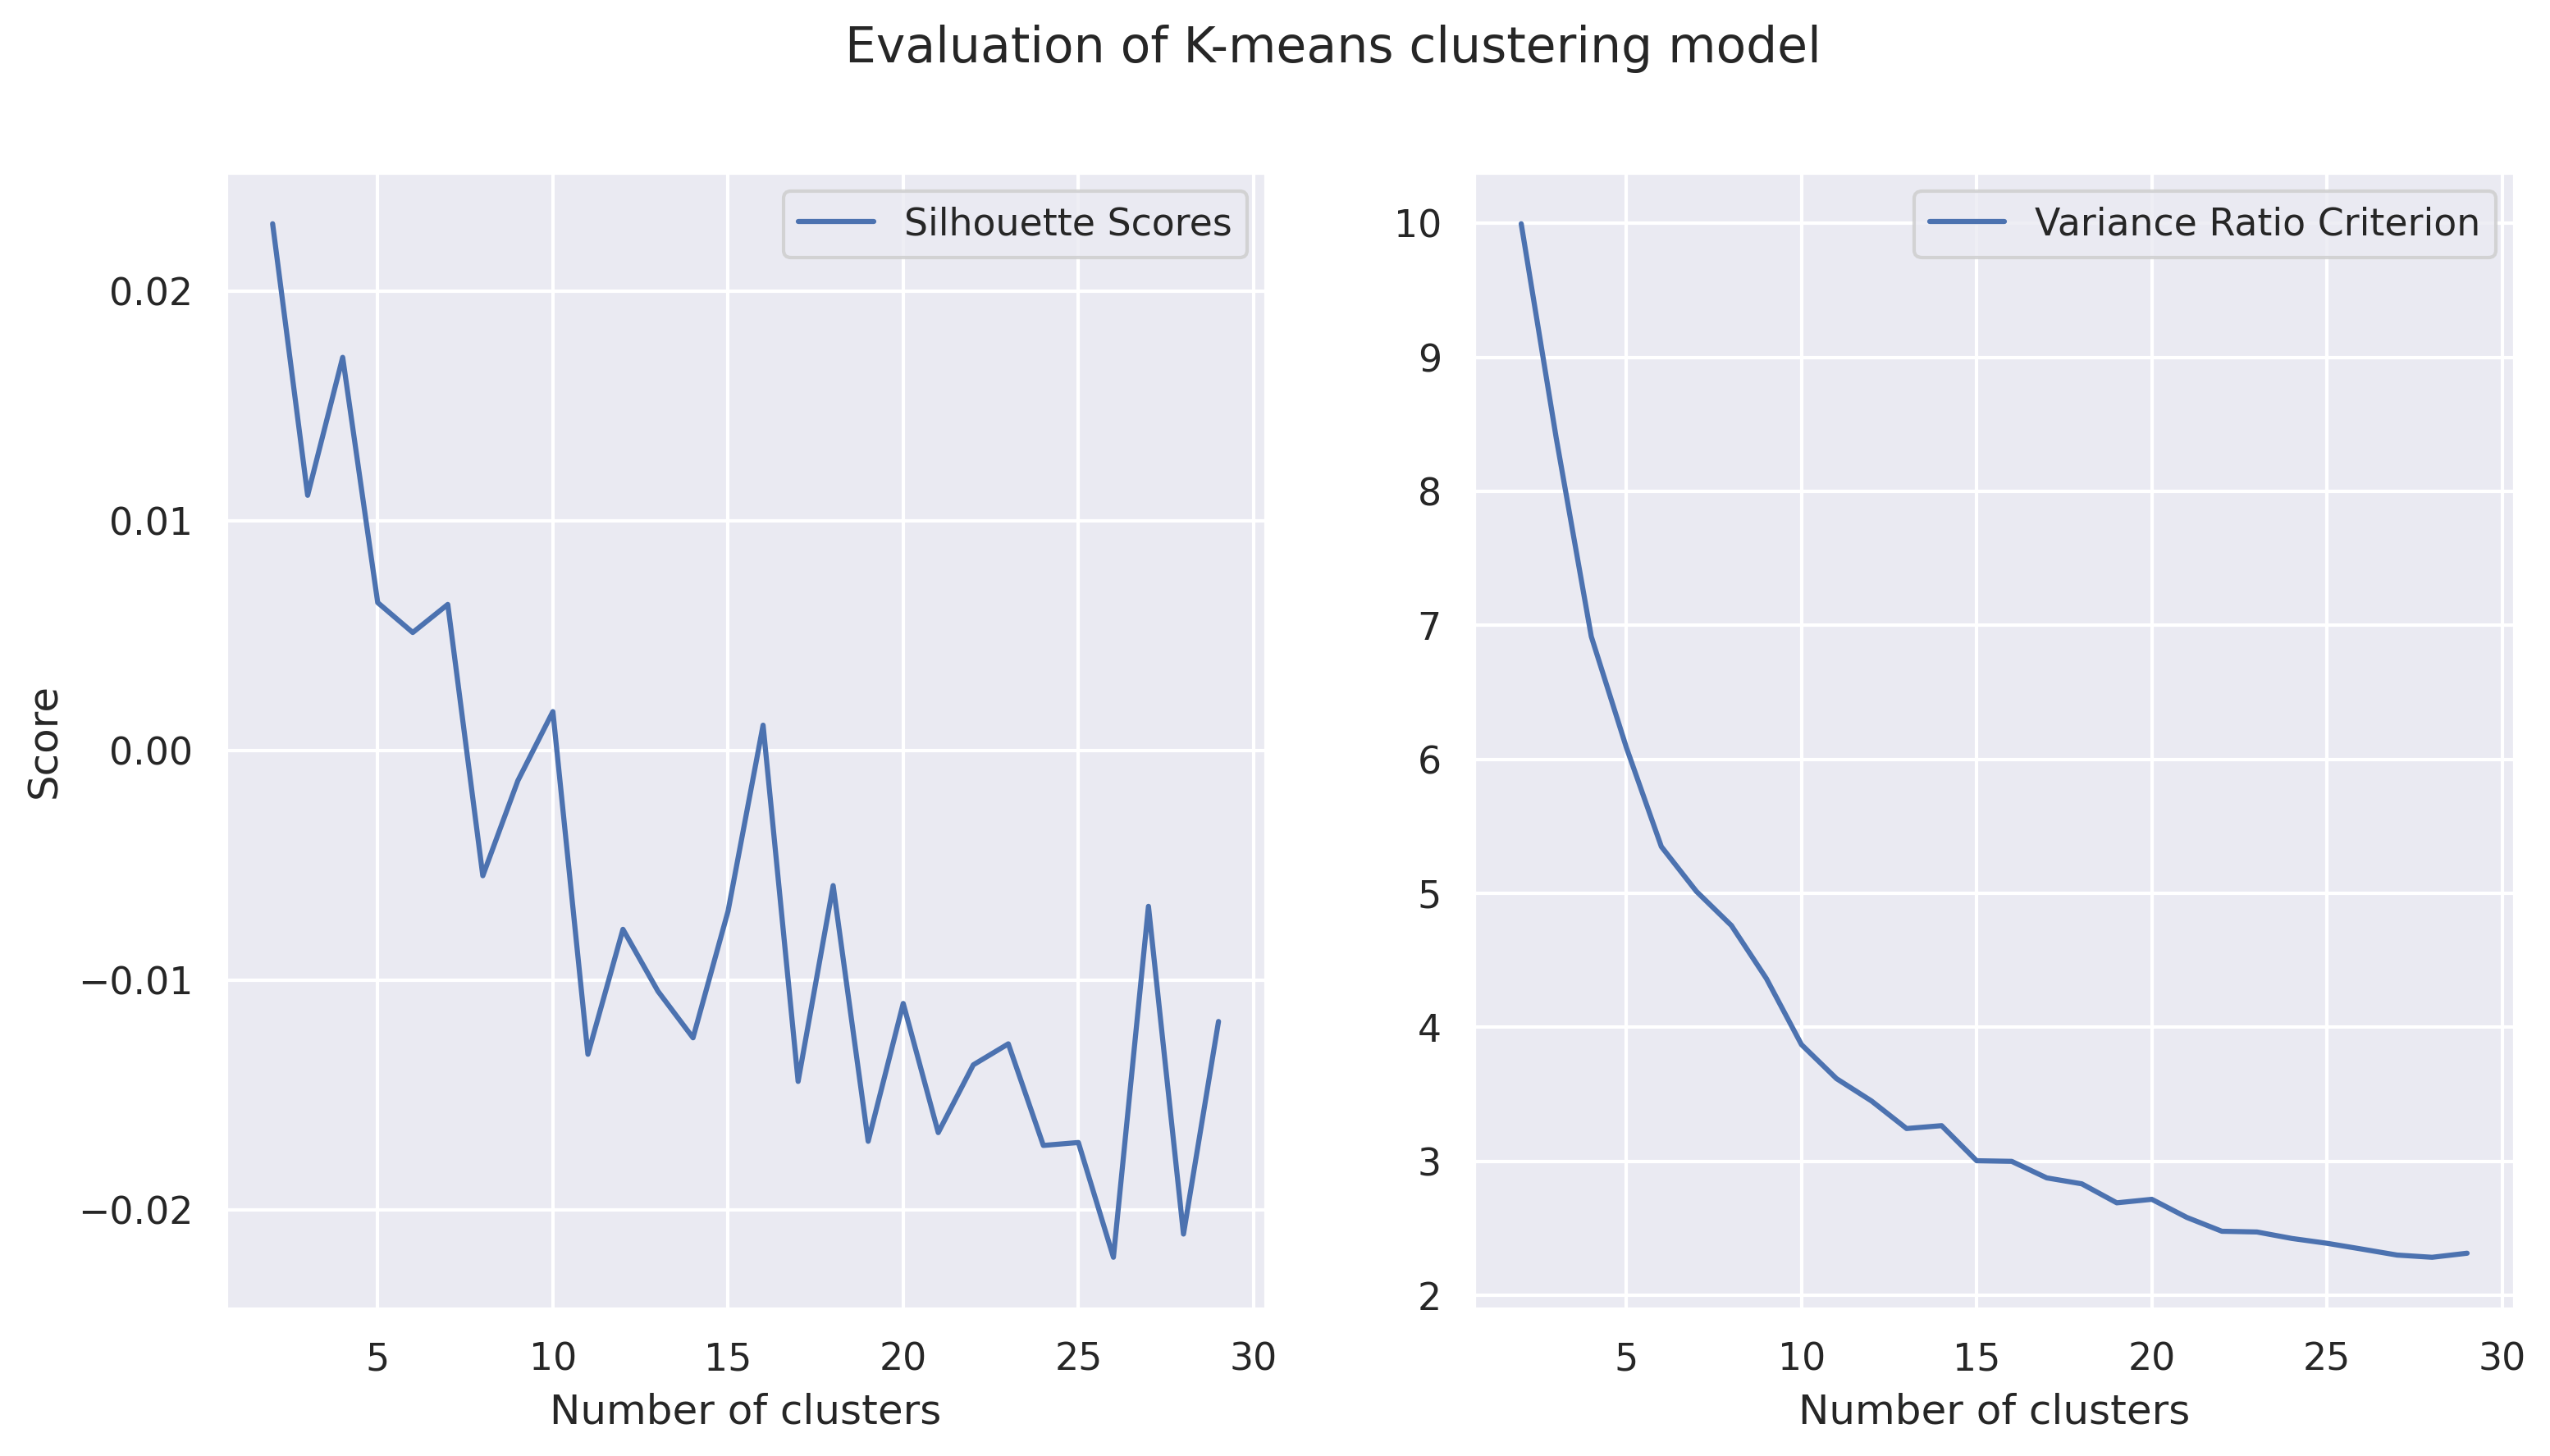

In [7]:
import sys

sys.path.append("..")
from src.evaluation import evaluate_clustering
import matplotlib.pyplot as plt

evaluate_clustering(range(2, 30), X, KMeans)
plt.suptitle("Evaluation of K-means clustering model")
plt.show()

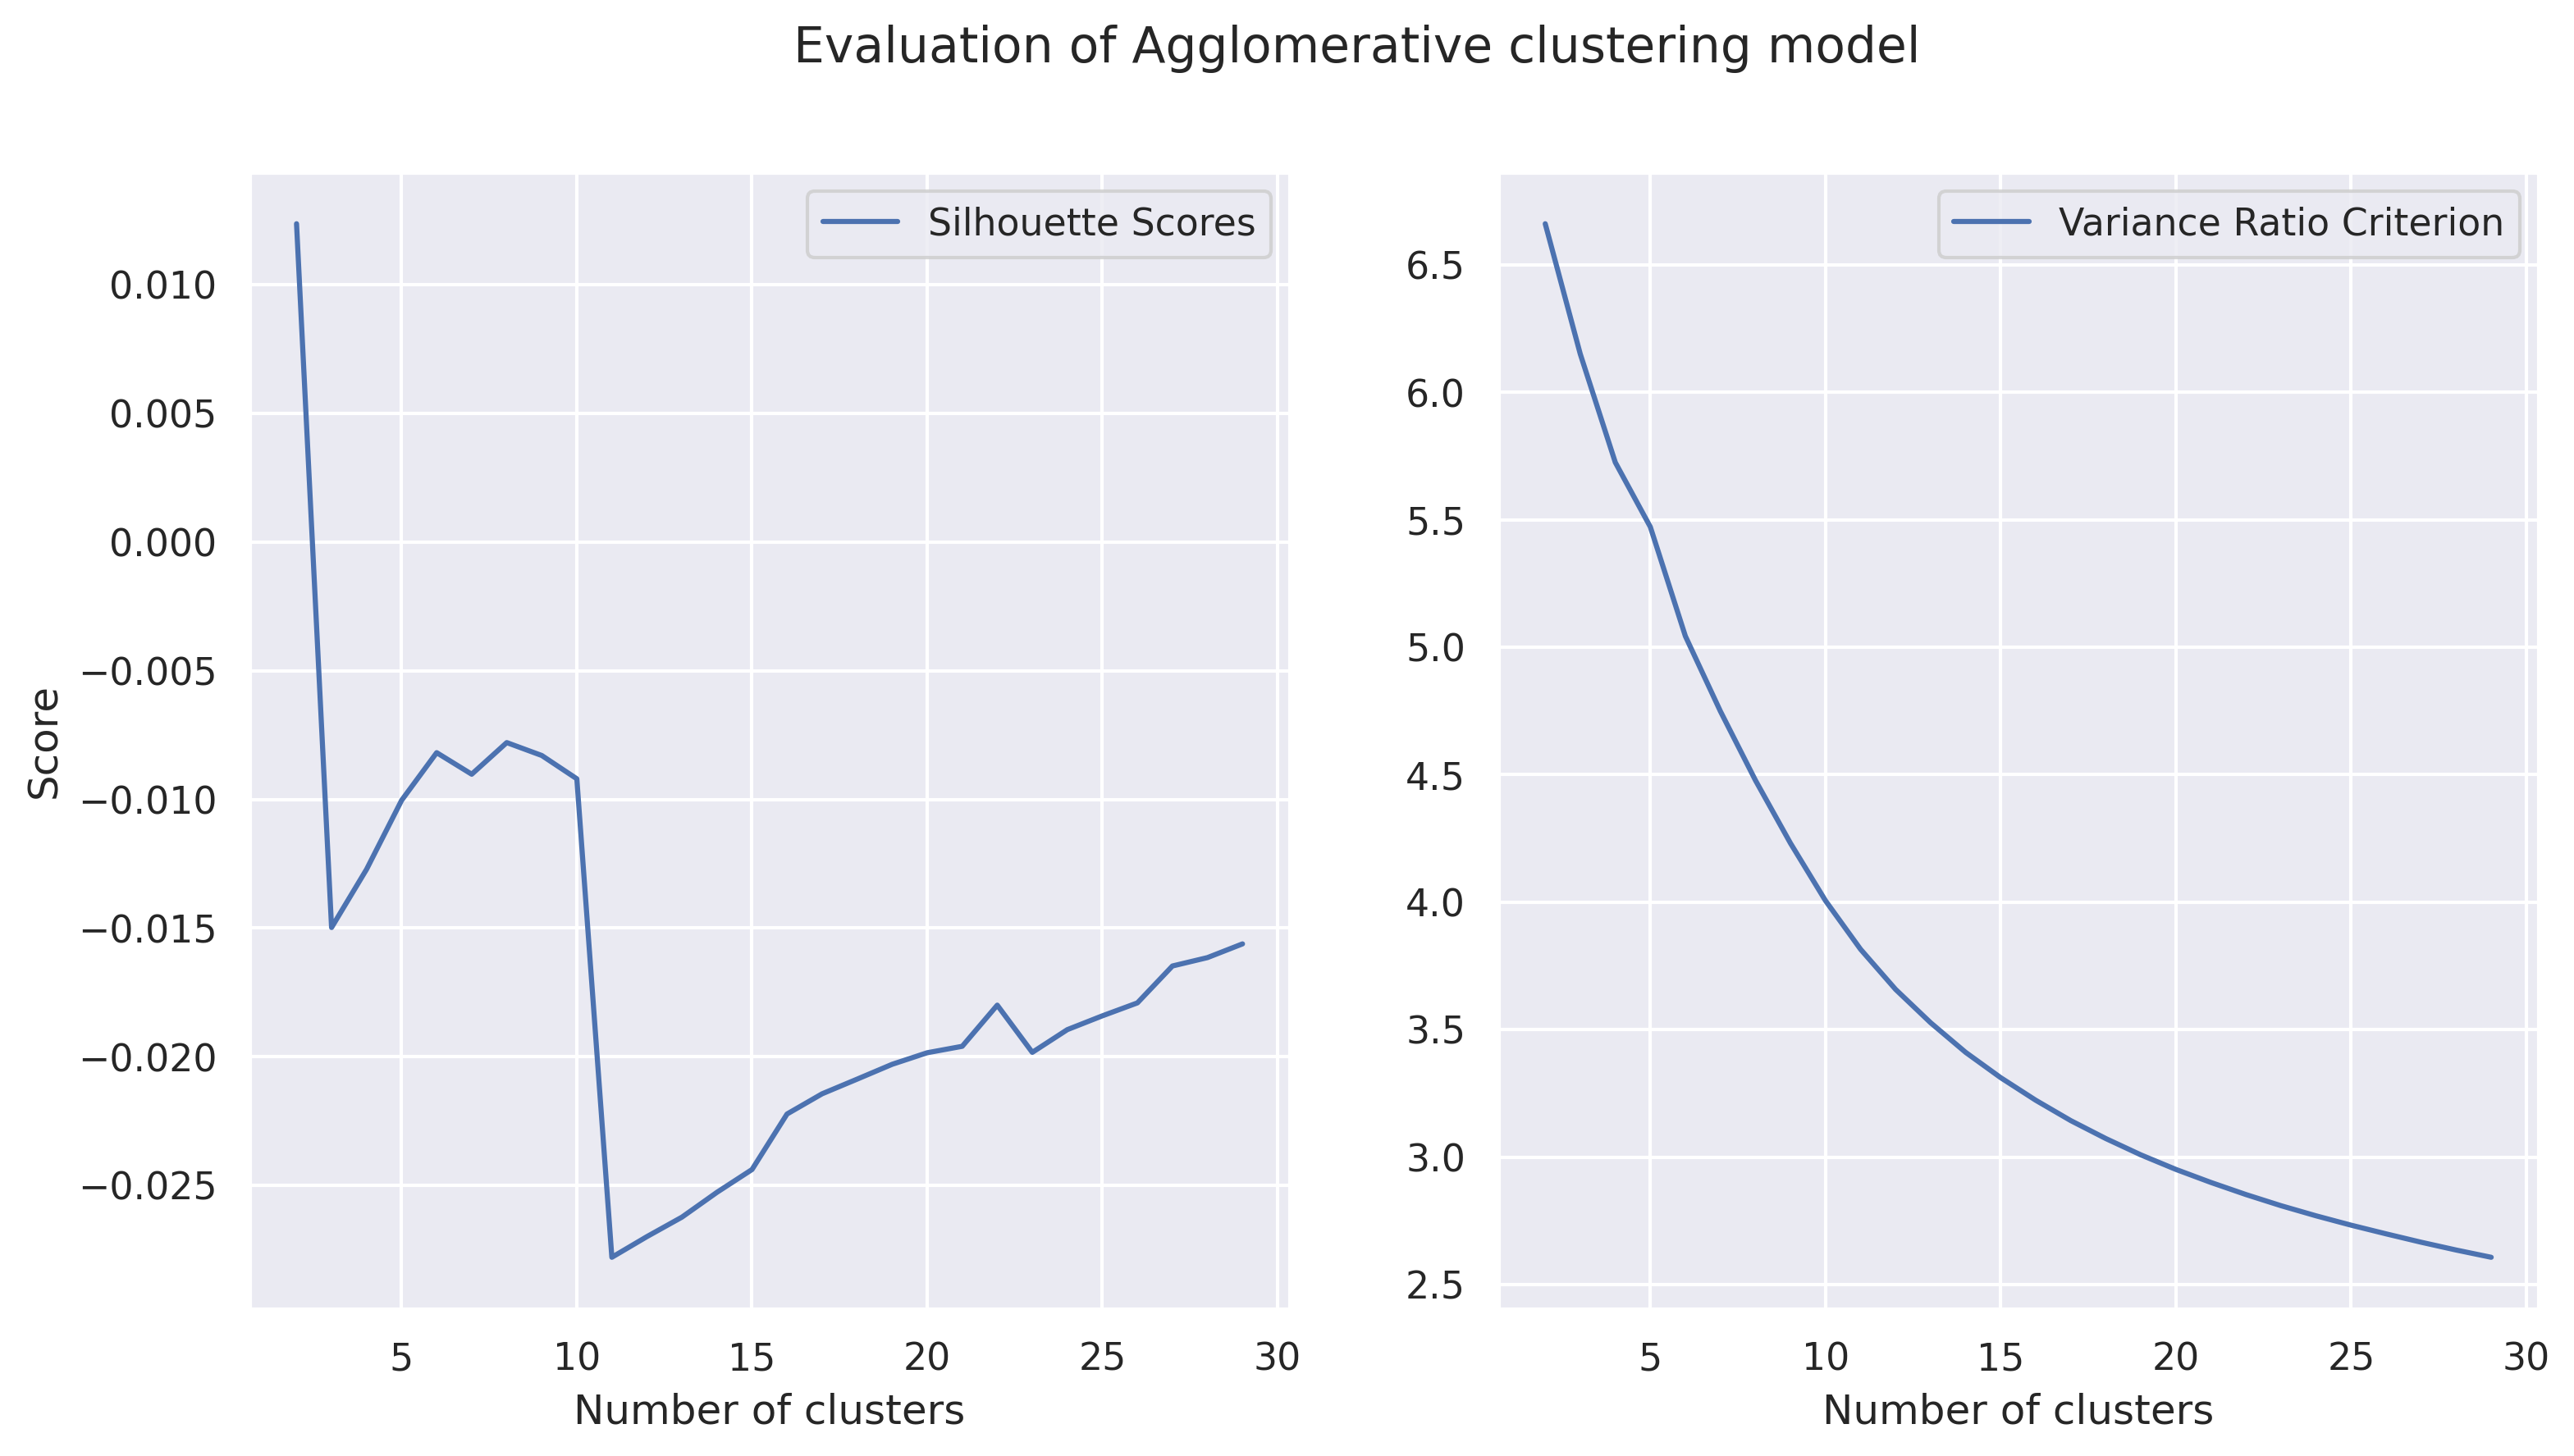

In [8]:
import sys

sys.path.append("..")
from src.evaluation import evaluate_clustering

evaluate_clustering(range(2, 30), X, AgglomerativeClustering)
plt.suptitle("Evaluation of Agglomerative clustering model")
plt.show()

## Predicting the labels

We will use 2 clusters, as we see that number yields the best agreement and scores.

In [9]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
y_kmeans = kmeans.fit_predict(X)
y_hierarchical = hierarchical.fit_predict(X)

### KMeans

In [10]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
grid = {
    "n_estimators": [10, 30, 50, 75, 100, 120, 150],
    "max_depth": [2, 3, 4, 5, 6, 7],
    "max_features": [2, 3, 4, 5],
    "random_state": [42],
}
grid_search = GridSearchCV(RandomForestClassifier(), grid, scoring="accuracy", cv=cv)

In [11]:
grid_search.fit(X, y_kmeans)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_features': [2, 3, 4, 5],
                         'n_estimators': [10, 30, 50, 75, 100, 120, 150],
                         'random_state': [42]},
             scoring='accuracy')

Text(0.5, 1.0, 'Feature Importance (MDI)')

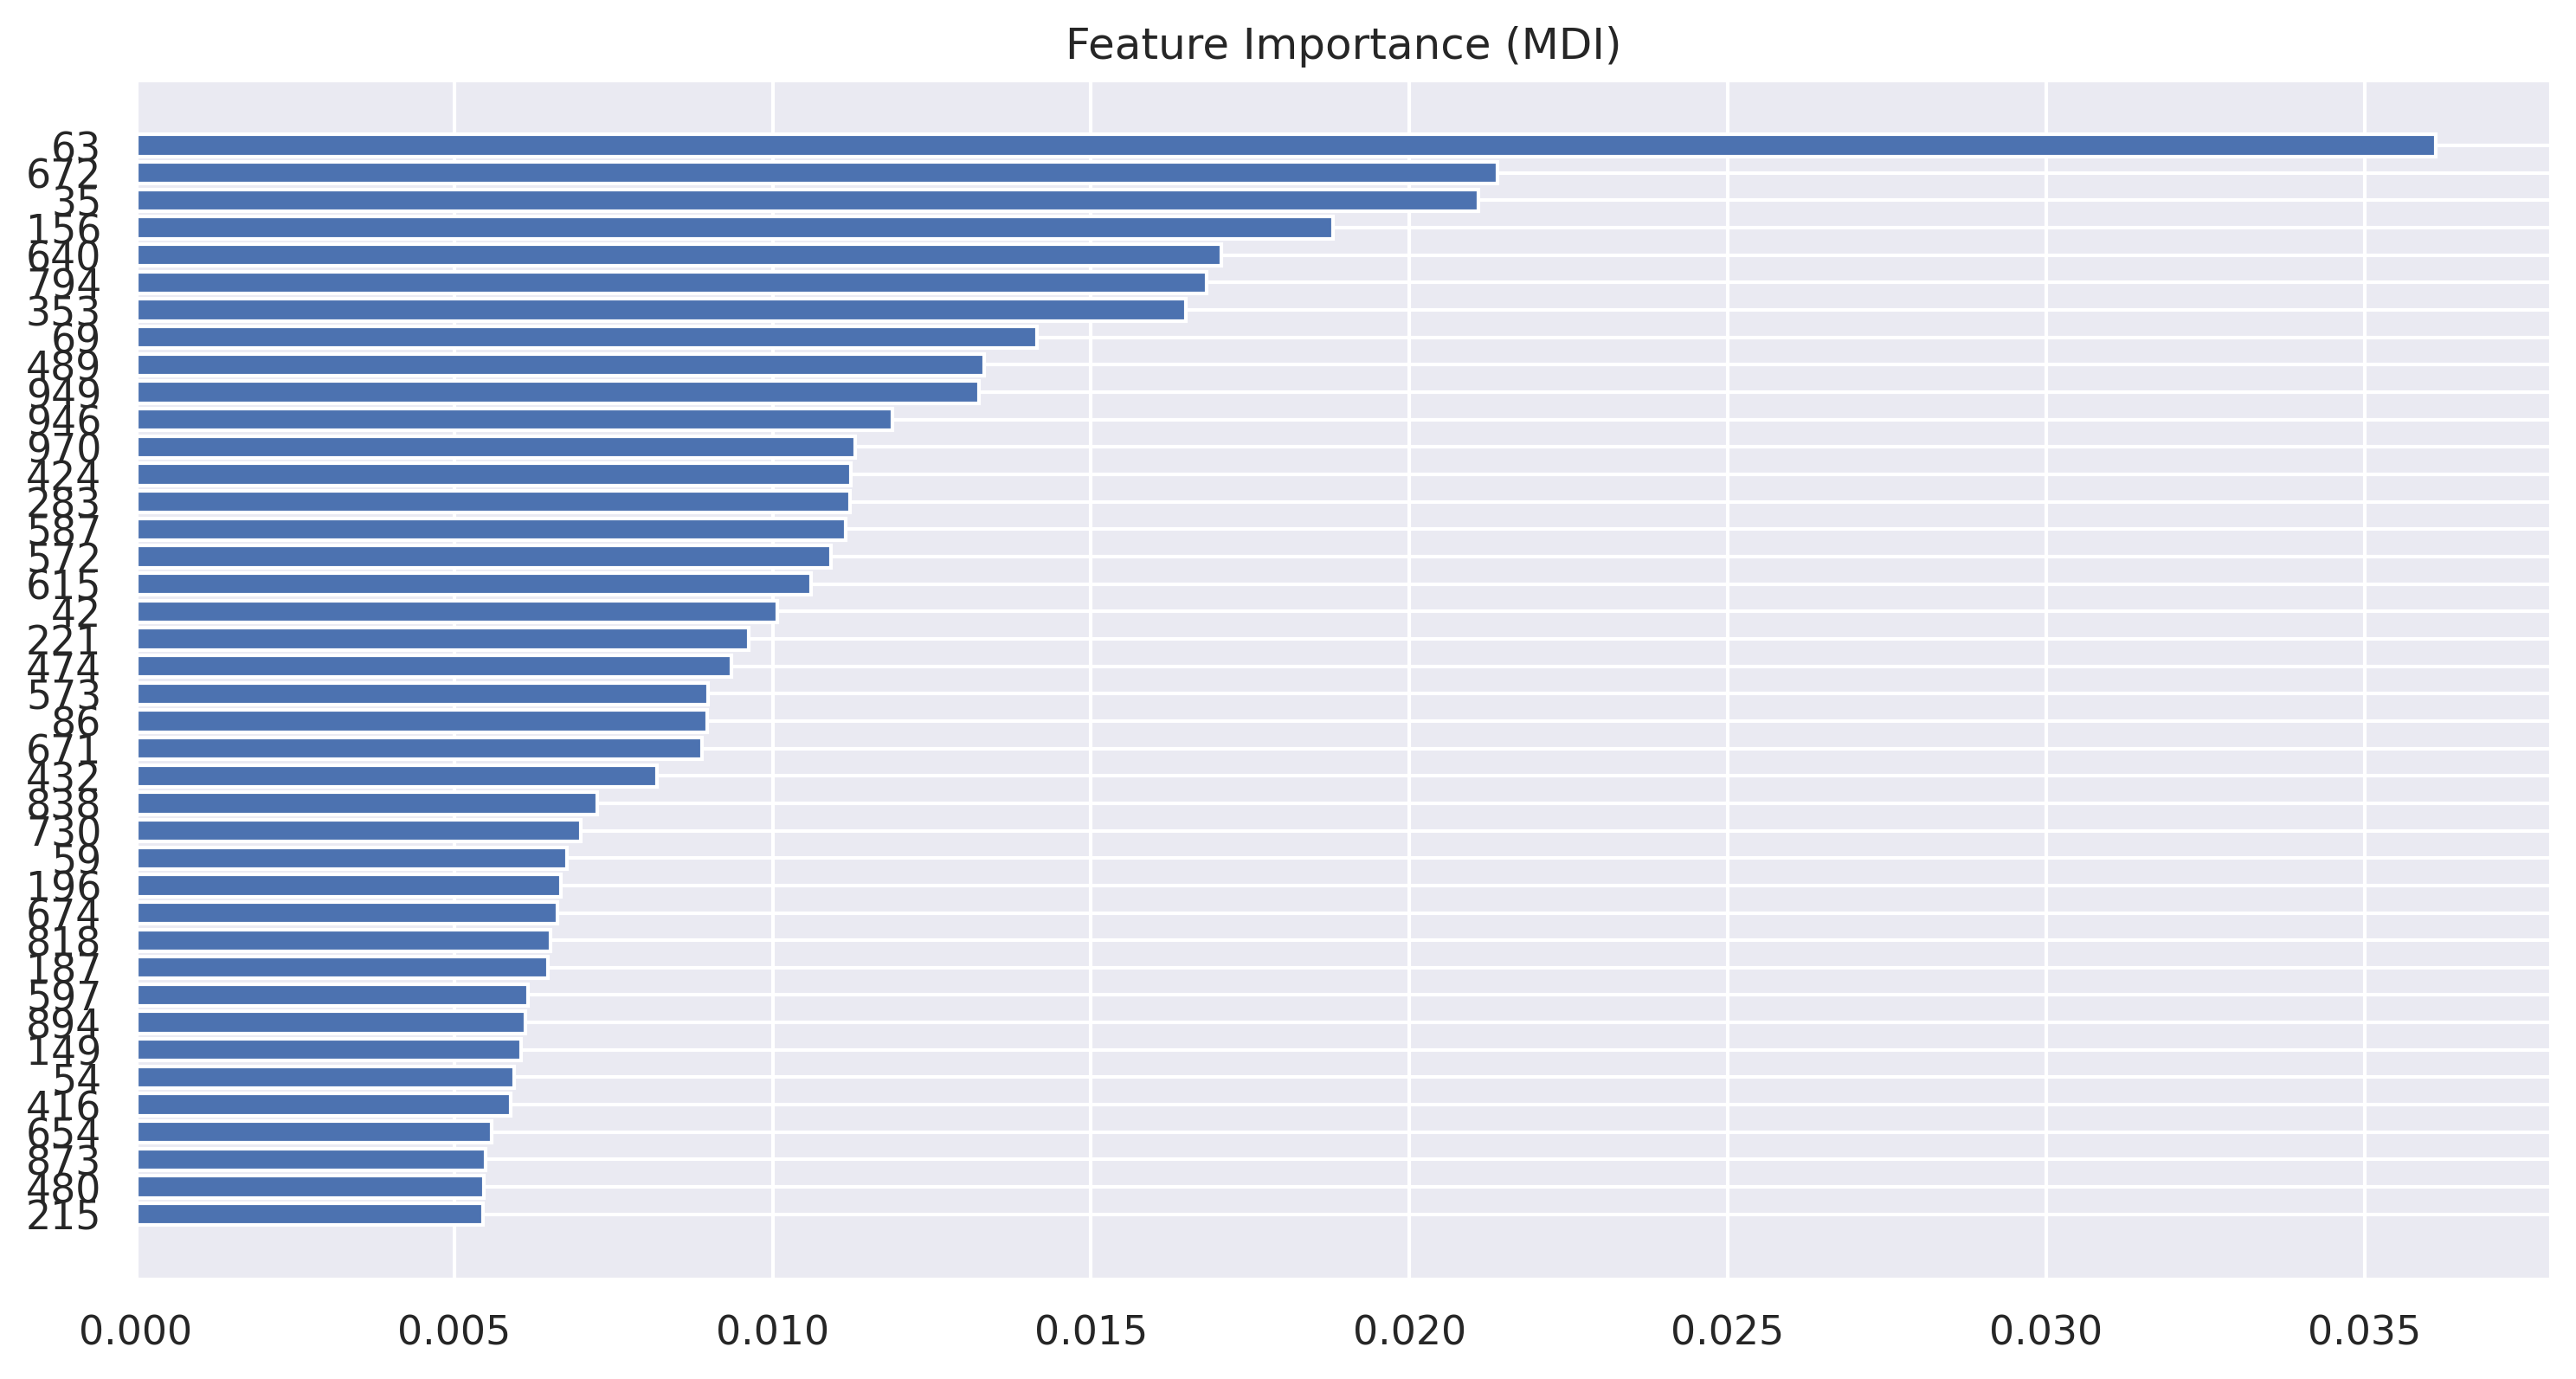

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Generate feature imporatnces from Random Forest
kmeans_feature_importance = grid_search.best_estimator_.feature_importances_
kmeans_sorted_idx = np.argsort(kmeans_feature_importance)[-40:]
pos = np.arange(kmeans_sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6), dpi=300)

plt.barh(pos, kmeans_feature_importance[kmeans_sorted_idx], align="center")
plt.yticks(
    pos, preprocessing_pipeline.nzremover.column_mask.nonzero()[0][kmeans_sorted_idx]
)
plt.title("Feature Importance (MDI)")

In [13]:
from src.clustering import compare_predictions

kmeans_limited = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_limited.fit(X[:, kmeans_sorted_idx[-10:]])
# Print contingency matrix
compare_predictions(
    kmeans.predict(X), kmeans_limited.predict(X[:, kmeans_sorted_idx[-10:]])
)

,CLUSTER 1 (PARTITION 2),CLUSTER 2 (PARTITION 2)
CLUSTER 1 (PARTITION 1),14,161
CLUSTER 2 (PARTITION 1),283,19


### Hierarchical Clustering

In [14]:
grid_search.fit(X, y_hierarchical)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_features': [2, 3, 4, 5],
                         'n_estimators': [10, 30, 50, 75, 100, 120, 150],
                         'random_state': [42]},
             scoring='accuracy')

Text(0.5, 1.0, 'Feature Importance (MDI)')

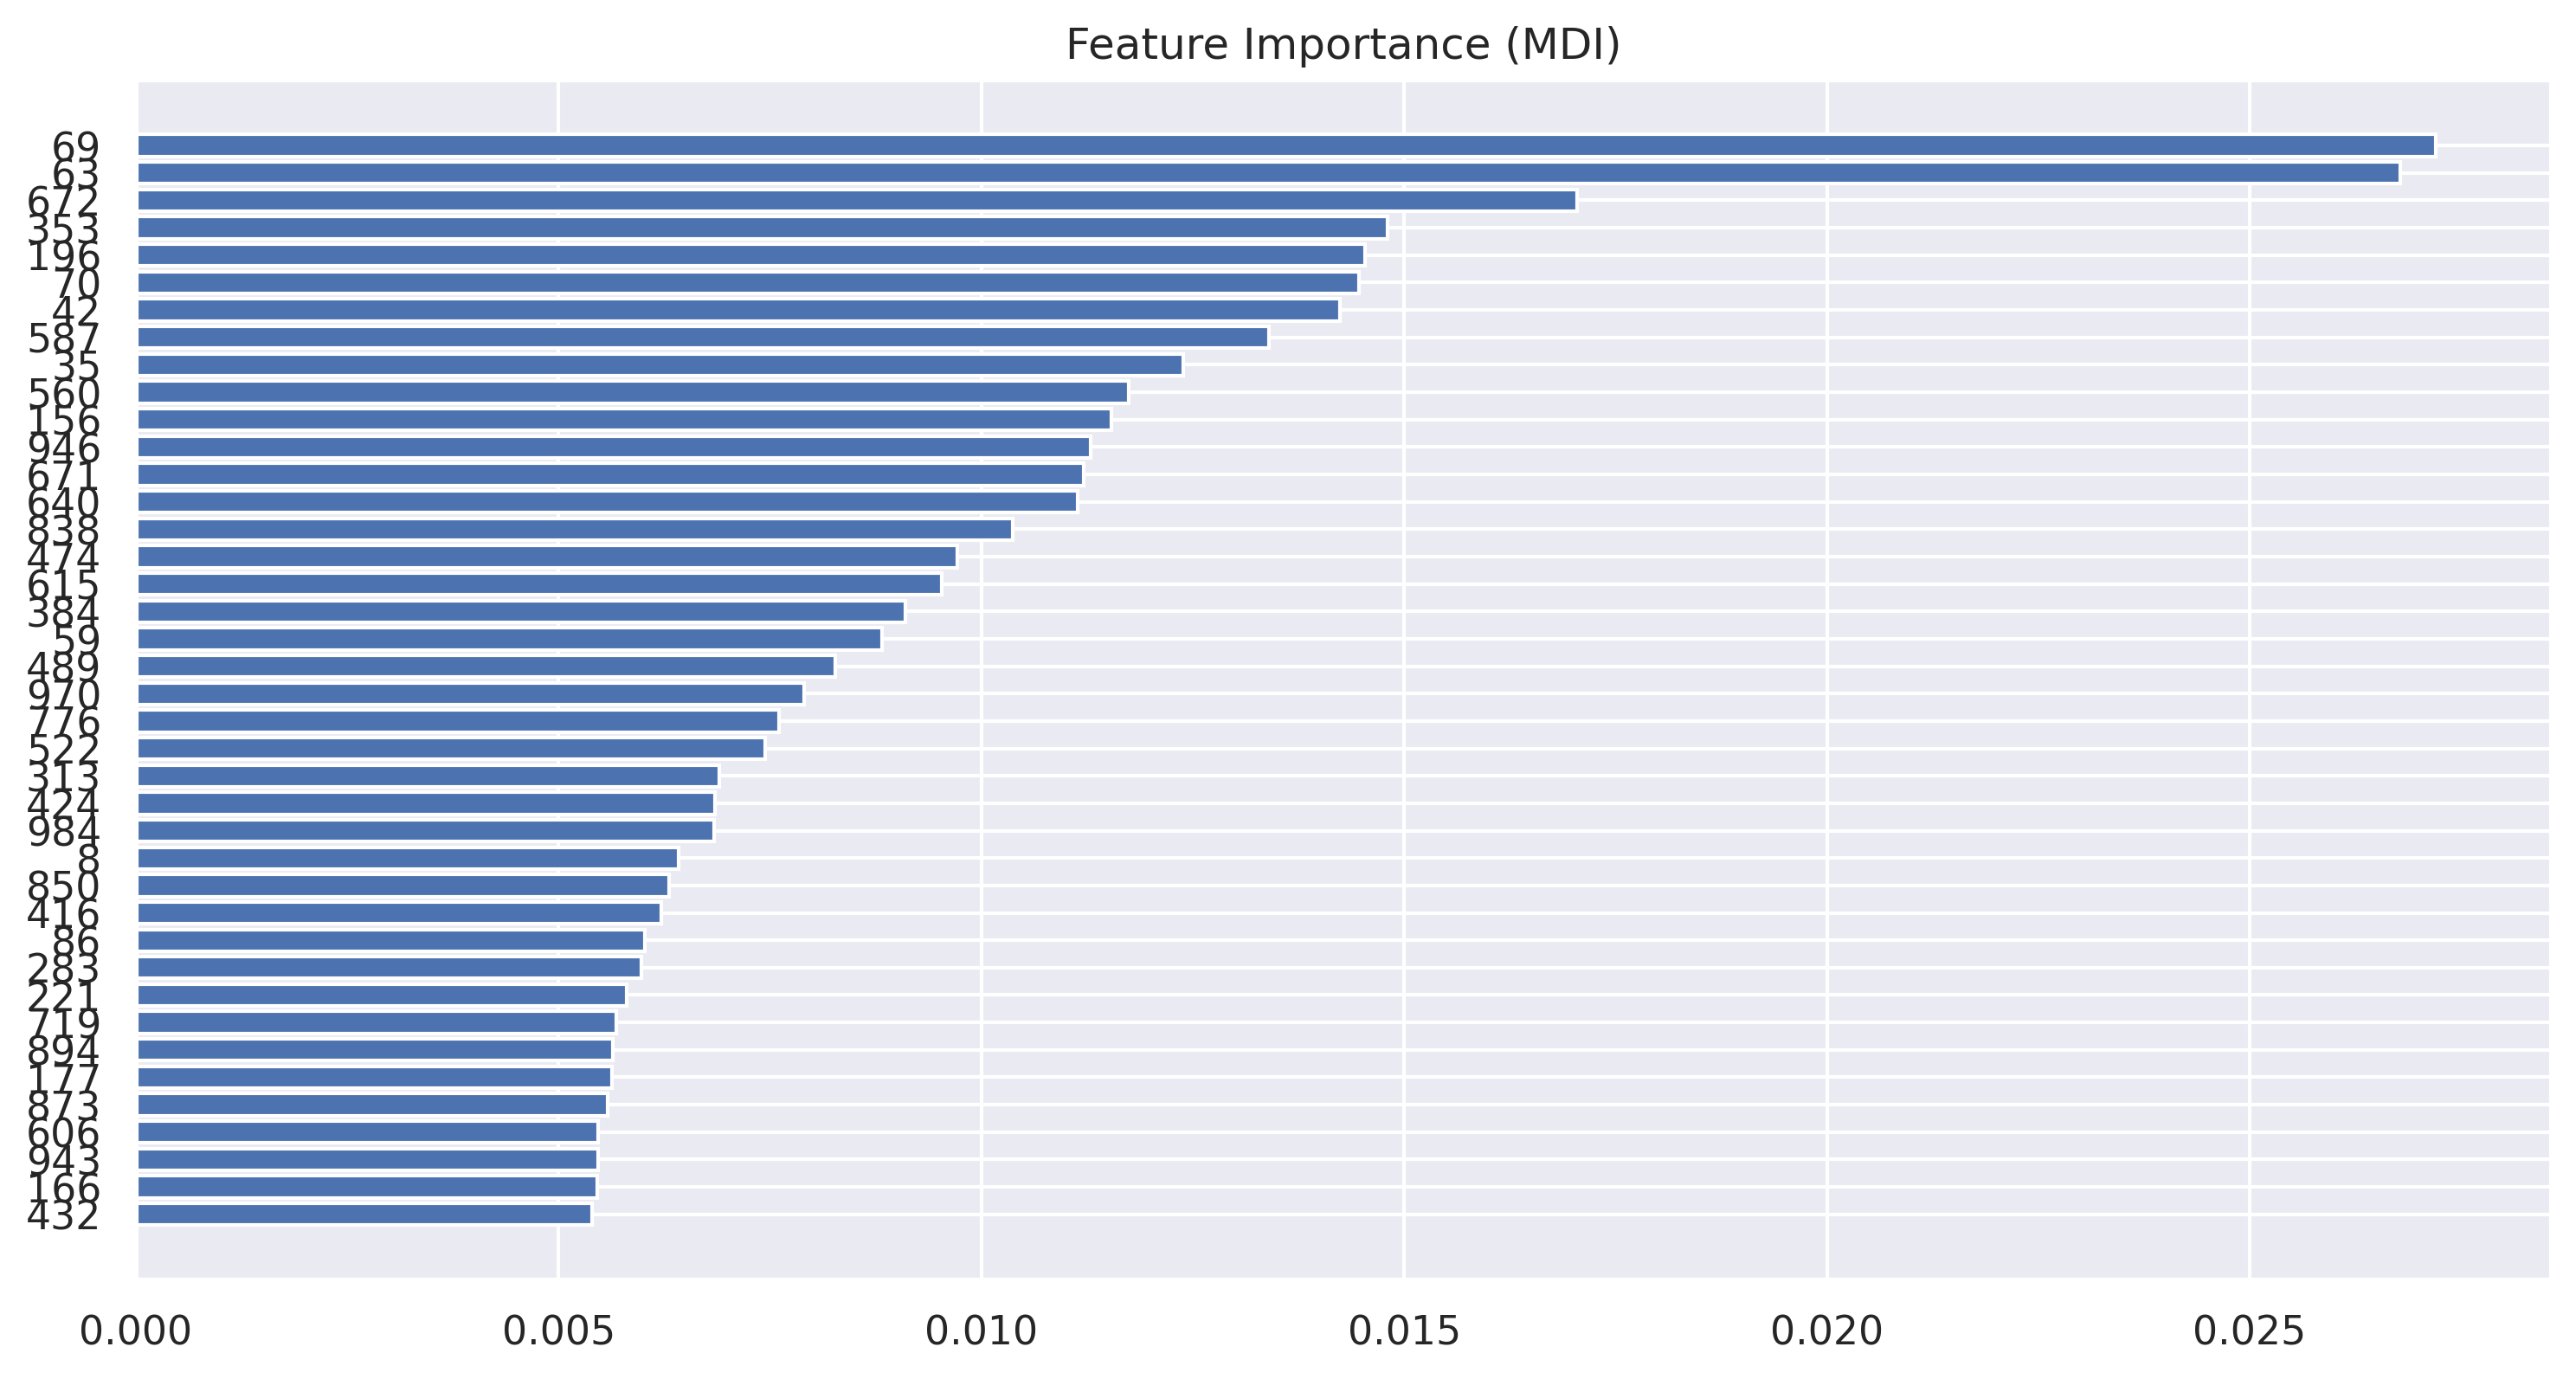

In [15]:
# Generate feature imporatnces from Random Forest
hierarchical_feature_importance = grid_search.best_estimator_.feature_importances_
hierarchical_sorted_idx = np.argsort(hierarchical_feature_importance)[-40:]
pos = np.arange(hierarchical_sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6), dpi=300)

plt.barh(pos, hierarchical_feature_importance[hierarchical_sorted_idx], align="center")
plt.yticks(
    pos,
    preprocessing_pipeline.nzremover.column_mask.nonzero()[0][hierarchical_sorted_idx],
)
plt.title("Feature Importance (MDI)")

In [16]:
hierarchical_limited = AgglomerativeClustering(n_clusters=n_clusters)
# Print contingency matrix
compare_predictions(
    hierarchical.fit_predict(X),
    hierarchical_limited.fit_predict(
        X[:, np.argsort(hierarchical_feature_importance)[-10:]]
    ),
)

,CLUSTER 1 (PARTITION 2),CLUSTER 2 (PARTITION 2)
CLUSTER 1 (PARTITION 1),225,12
CLUSTER 2 (PARTITION 1),107,133


# Visualisation

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca.fit(X)

PCA(n_components=2, random_state=42)

Text(0.5, 1.0, 'KMeans Clusters colored by membership')

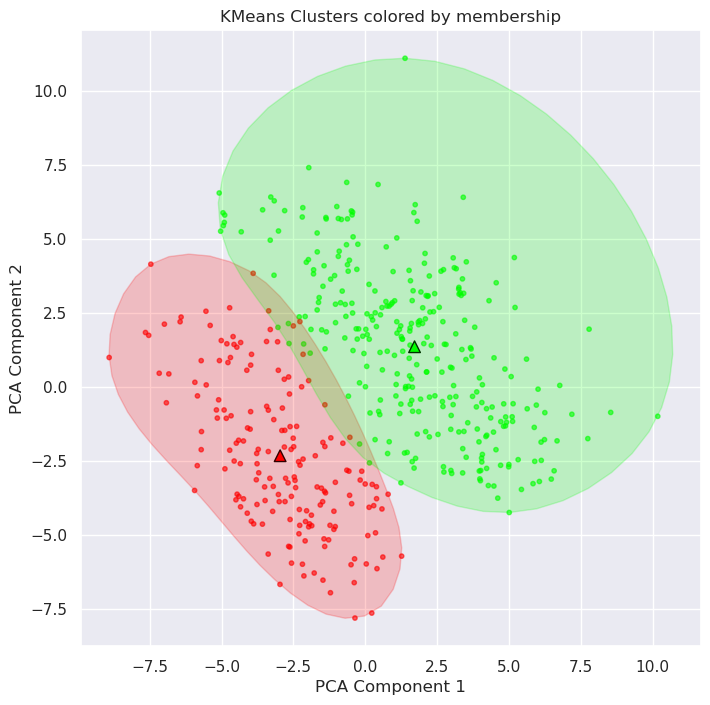

In [18]:
sys.path.append("..")
from src.plotting import visualize_clusters

visualize_clusters(X, kmeans, pca, 2)
plt.title("KMeans Clusters colored by membership")

Text(0.5, 1.0, 'KMeans Clusters colored by most discrimnative feature')

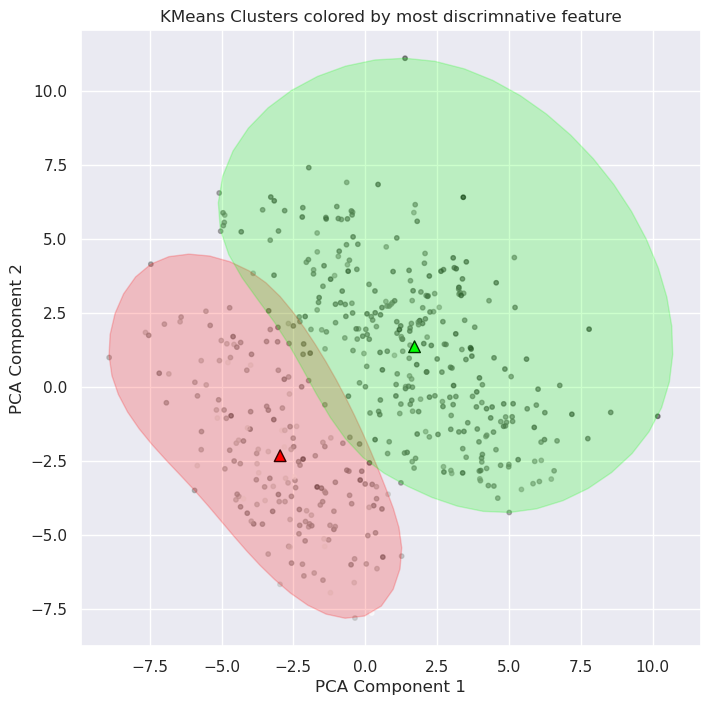

In [19]:
visualize_clusters(
    X,
    kmeans,
    pca,
    2,
    hues=X[:, np.argsort(kmeans_feature_importance)[-1]],
    cmap="Greys",
)
plt.title("KMeans Clusters colored by most discrimnative feature")

Text(0.5, 1.0, 'KMeans Clusters colored by 2nd most discriminative feature')

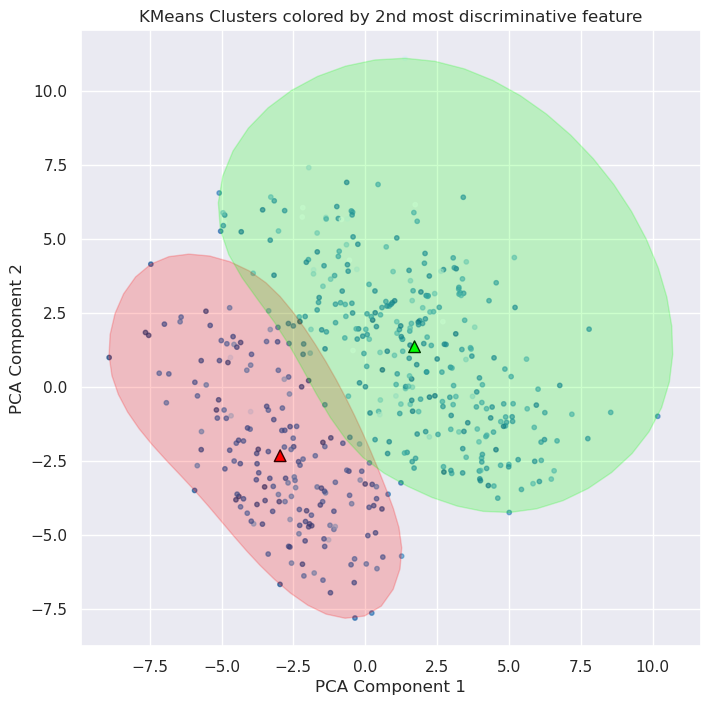

In [20]:
visualize_clusters(
    X,
    kmeans,
    pca,
    2,
    hues=X[:, np.argsort(kmeans_feature_importance)[-2]],
    cmap="Blues",
)
plt.title("KMeans Clusters colored by 2nd most discriminative feature")

Text(0.5, 1.0, 'HAC Clusters colored by membership')

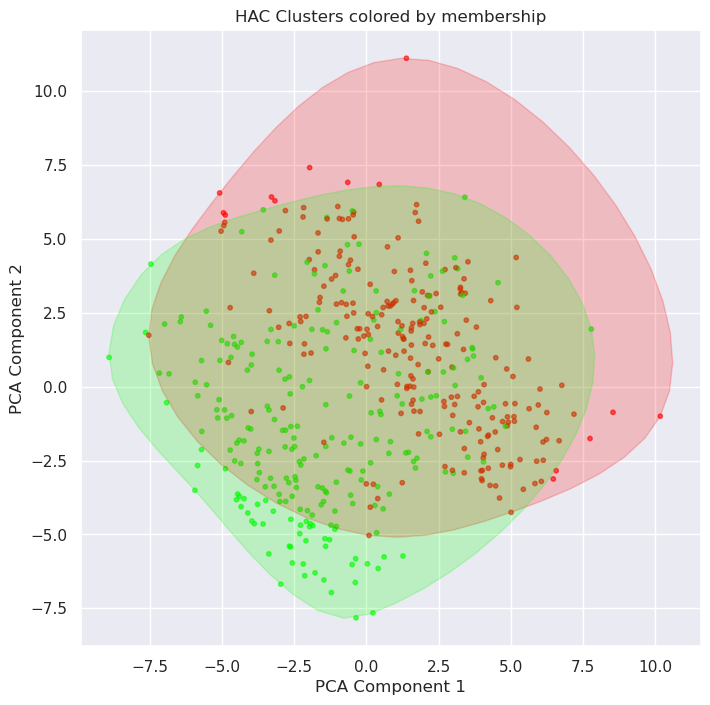

In [21]:
visualize_clusters(X, hierarchical, pca, 2, has_centroids=False)
plt.title("HAC Clusters colored by membership")

Text(0.5, 1.0, 'HAC Clusters colored by 2nd most discriminative feature')

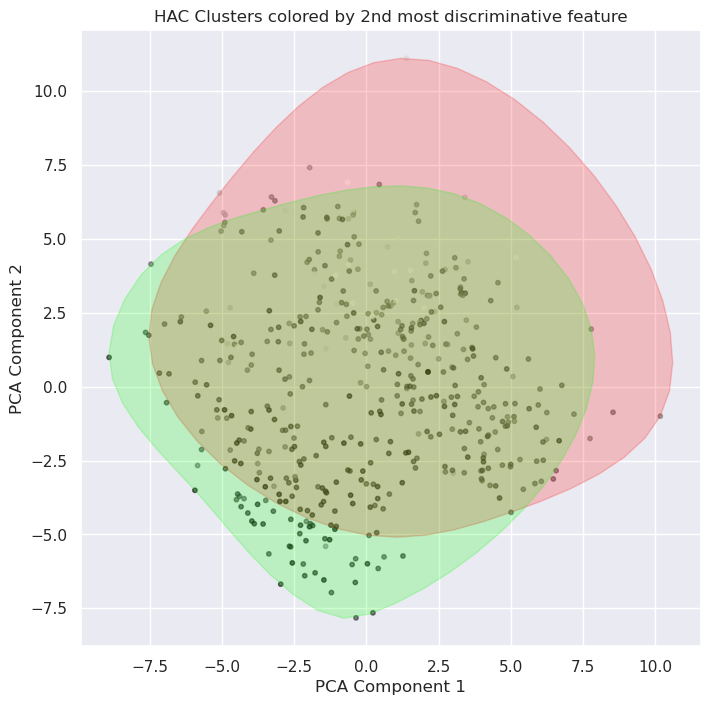

In [22]:
visualize_clusters(
    X,
    hierarchical,
    pca,
    2,
    hues=X[:, np.argsort(hierarchical_feature_importance)[-1]],
    cmap="Greys",
    has_centroids=False,
)
plt.title("HAC Clusters colored by 2nd most discriminative feature")

Text(0.5, 1.0, 'HAC Clusters colored by 2nd most discriminative feature')

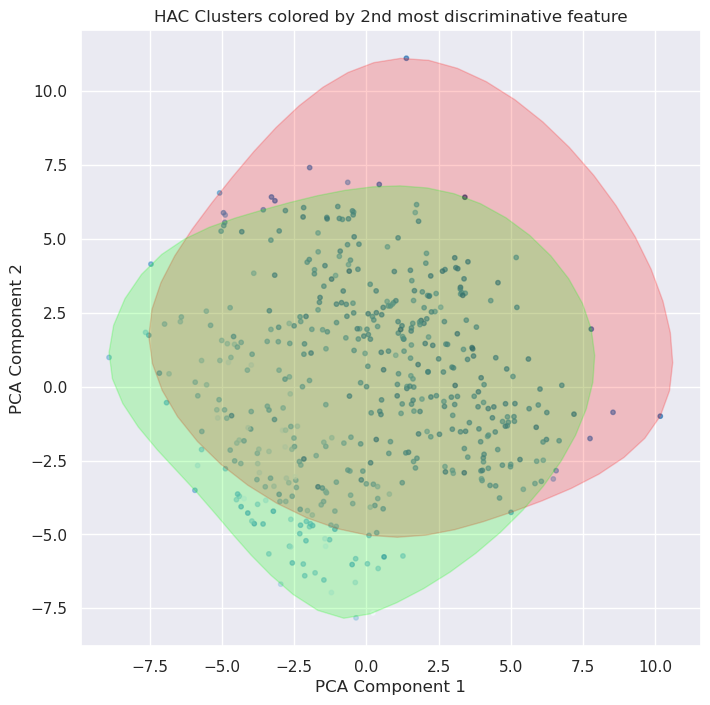

In [23]:
visualize_clusters(
    X,
    hierarchical,
    pca,
    2,
    hues=X[:, np.argsort(hierarchical_feature_importance)[-2]],
    cmap="Blues",
    has_centroids=False,
)
plt.title("HAC Clusters colored by 2nd most discriminative feature")